# Overview

The purpose of this jupyter notebook is to outline a the problem, approach, and outcomes associated with the detection of "truthful" and "deceptive" hotel reviews that a typical hotel review aggregator (or some sort of similar service) would come across as important to business operations.

This notebook is structured in the following manner:
0. **Motivation**: The problem, and why it is important
1. **Setting up**: Tools, models, Data utilized
2. **Description**: A description of the data
3. **Data transformation**: Steps that facilitate the detection stage
4. **Classification and Tuning**: The actual dete
5. **Results**

## 1. Motivation

The problem of detecting truthful versus deceptive content is an important focus in many areas including spam detection, consumer-facing information about businesses, and even political information in democratic societies (fake news). 

The purpose of this project focuses on consumer-facing information. Given a data set of about 1600 hotel reviews, where 800 are truthful (pulled from sources such as Trip Advisor), and 800 are deceptive (Generated using Amazon's Mechanical Turk -- a market place for tasks requiring human intelligence), this notebook seeks to detect deceptive reviews by using latent semantic indexing and machine learning. 

## 2. Setting Up

In [1]:
# General Data Manipulation
import pandas
import numpy
import re

# Feature Engineering, Descriptives
from scipy.stats import ttest_ind
from nltk.corpus import stopwords
from collections import defaultdict

# NLP Modules
import gensim 
import spacy

# Supervised Learning Modules
from sklearn.lda import LDA 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Package Results
from sklearn.externals import joblib

# Plotting
from matplotlib import pyplot
%matplotlib inline

# Read Data
data_in = pandas.read_csv('deceptive-opinion.csv')
stop = set(stopwords.words('english'))

import warnings
warnings.filterwarnings('ignore')

C:\Users\Chris\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


## 3. Description of Data

    A. Show the top 5 and bottom 5 records.
    B. Pivot table on categorical labels, and count.
    C. Barplot data
    D. Hypothesis testing

### A. Head / Tail of Data

In [2]:
data_in.head(3).append(data_in.tail(3))

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...
1597,deceptive,intercontinental,negative,MTurk,The Intercontinental Chicago Magnificent Mile ...
1598,deceptive,palmer,negative,MTurk,"The Palmer House Hilton, while it looks good i..."
1599,deceptive,amalfi,negative,MTurk,"As a former Chicagoan, I'm appalled at the Ama..."


### B. Pivot Table by Categories

In [3]:
data_in.pivot_table(
    columns=['deceptive','polarity'],
    index = ['hotel'],
    aggfunc = len).fillna(0)

source                                 text           \
deceptive        deceptive          truthful          deceptive            
polarity          negative positive negative positive  negative positive   
hotel                                                                      
affinia                 20       20       20       20        20       20   
allegro                 20       20       20       20        20       20   
amalfi                  20       20       20       20        20       20   
ambassador              20       20       20       20        20       20   
conrad                  20       20       20       20        20       20   
fairmont                20       20       20       20        20       20   
hardrock                20       20       20       20        20       20   
hilton                  20       20       20       20        20       20   
homewood                20       20       20       20        20       20   
hyatt                   20       20       20       20        20       20   
intercontinental        20       20       20       20        20       20   
james                   20       20       20       20        20       20   
knickerbocker           20       20       20       20        20       20   
monaco                  20       20       20       20        20       20   
omni                    20       20       20       20        20       20   
palmer                  20       20       20       20        20       20   
sheraton                20       20       20       20        20       20   
sofitel                 20       20       20       20        20       20   
swissotel               20       20       20       20        20       20   
talbott                 20       20       20       20        20       20   

                                    
deceptive        truthful           
polarity         negative positive  
hotel                               
affinia                20       20  
allegro                20       20  
amalfi                 20       20  
ambassador             20       20  
conrad                 20       20  
fairmont               20       20  
hardrock               20       20  
hilton                 20       20  
homewood               20       20  
hyatt                  20       20  
intercontinental       20       20  
james                  20       20  
knickerbocker          20       20  
monaco                 20       20  
omni                   20       20  
palmer                 20       20  
sheraton               20       20  
sofitel                20       20  
swissotel              20       20  
talbott                20       20

### C. Barplot of Various Text Features

From the descriptive charts below, there seems to be no difference in deceptive review length on average. On average, Positive reviews are shorter than negative.

In [4]:
#Mean Length Funciton
def mean_len(group, mean = True):
    if mean == True:
        return numpy.mean(group.text.str.len())
    else:
        return group.text.str.len()

In [5]:
a = data_in.groupby(
    ['deceptive']).apply(
    mean_len, mean = True)

b = data_in.groupby(
    ['polarity']).apply(
    mean_len, mean = True)

c = data_in.groupby(
    ['deceptive','polarity']).apply(
    mean_len, mean = True)

d = data_in.groupby(
    ['hotel','polarity']).apply(
    mean_len, mean = True)

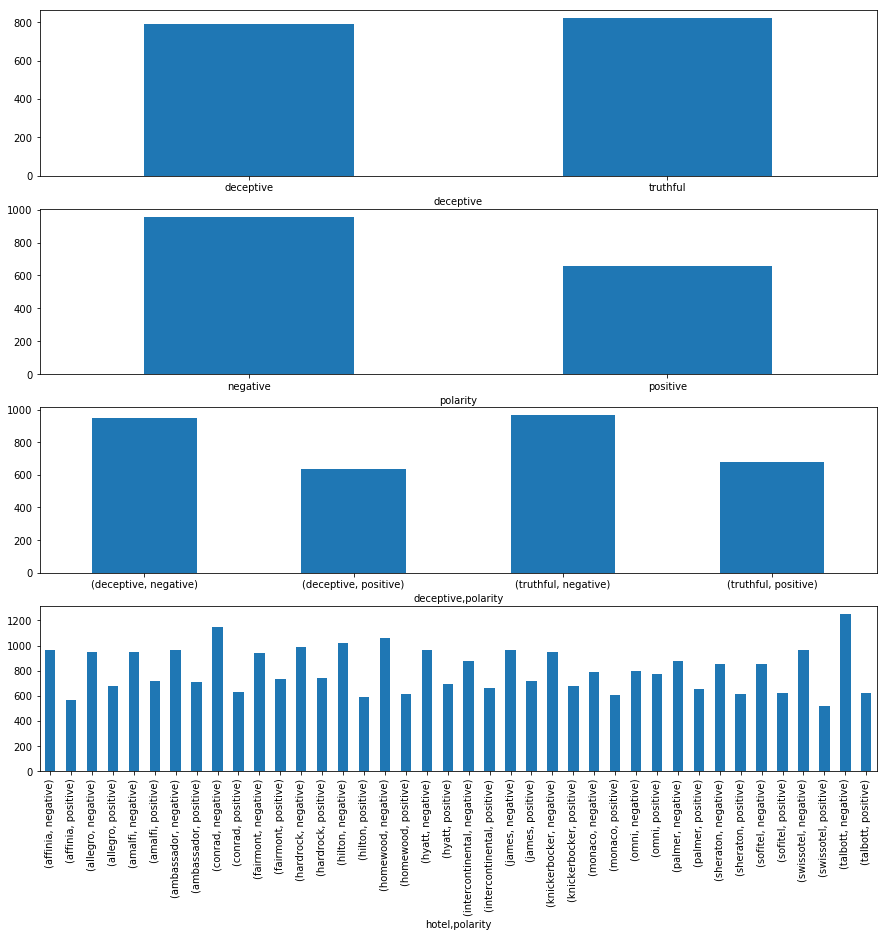

In [6]:
fig, ax =pyplot.subplots(4,1,figsize=(15,14))

a.plot('bar',ax = ax[0], rot = 0 )

b.plot('bar',ax = ax[1], rot = 0 )

c.plot('bar',ax = ax[2], rot = 0)

d.plot('bar',ax = ax[3])

### A. Hypothesis Tests on Text Features

From the results of hypotheses tests we cna see that:

1. There is a statistically signifincant difference between positive and negative average length of words (p-value of about 0)
2. There is a statistically signifincant difference between trip advisor and non trip advisor sources (p-value of about 0)
3. There is a no detectable statistical significance when it comes to deceptive and genuine reviews. (p-value = .2)

In [8]:
pandas.set_option('display.float_format', lambda x: '%.f' % x)

test_a = ttest_ind(
    data_in[data_in.polarity == 'positive'].text.str.len(),
    data_in[data_in.polarity == 'negative'].text.str.len())

test_b = ttest_ind(
    data_in[data_in.source == 'TripAdvisor'].text.str.len(),
    data_in[data_in.source != 'TripAdvisor'].text.str.len())

test_c = ttest_ind(
    data_in[data_in.deceptive == 'deceptive'].text.str.len(),
    data_in[data_in.deceptive == 'truthful'].text.str.len())


In [9]:
print('Positive vs Negative: Statisitcally Significant'), 
print(test_a)

Positive vs Negative: Statisitcally Significant
Ttest_indResult(statistic=-13.507204854821099, pvalue=1.8968798894685588e-39)


In [10]:
print('TripAdvisor vs Non TripAdvisor:  Statisitcally Significant'), 
print(test_b)

TripAdvisor vs Non TripAdvisor:  Statisitcally Significant
Ttest_indResult(statistic=-6.4399626289335314, pvalue=1.5767614748756925e-10)


In [11]:
print('Deceptive vs Truthfull: Not Statistically Significant'), 
print(test_c)

Deceptive vs Truthfull: Not Statistically Significant
Ttest_indResult(statistic=-1.2520931090803307, pvalue=0.21071916472895064)


# 4. Data Transformations

    A. Parse Data
    B. Create Features
    C. Topic Modeling
    D. Dummy variables

## A. Set up Instance and Parse Data

In [13]:
# Create Instance and Add Data to NLP object.
data_nlp = data_in.copy()
import en_core_web_md
nlp = en_core_web_md.load()

ModuleNotFoundError: No module named 'en_core_web_md'

In [ ]:
parsed = nlp.pipe(iter(data_nlp['text']), batch_size=1, n_threads=4)

# Create Features
tokens, lemma, parts, stopword = [], [], [], []

for parsed_doc in parsed:
    tokens.append([n.text for n in parsed_doc])
    lemma.append([n.lemma_ for n in parsed_doc])
    parts.append([n.pos_ for n in parsed_doc])
    stopword.append([n.is_stop for n in parsed_doc])

# Assign Parsed into Dataframe
data_nlp['tokens'] = tokens     
data_nlp['tokens_stopwords'] = data_nlp['tokens'].apply(lambda x: [item for item in x if item not in stop])
data_nlp['lemma'] = lemma
data_nlp['pos'] = parts
data_nlp['stopword'] = stopword

# Describe resulting frame
data_nlp.head(2).append(data_nlp.tail(2))

## B. Create Features from Parsed Data

In [ ]:
# Set up dataframe columns for new metrics
pron_ct = []
noun_ct = []
punct_ct = []
verb_ct = []
# tag parts of speech
for row in data_nlp.pos:
    pron_ct.append(sum([i == 'PRON'  for i in row]))
    noun_ct.append(sum([i == 'NOUN'  for i in row]))
    punct_ct.append(sum([i == 'PUNCT'  for i in row]))
    verb_ct.append(sum([i == 'VERB'  for i in row]))

## Create Number of stopword
stop_row = []
for row in data_nlp.stopword:
    stop_row.append(sum(row))
    
# Create POS Counts
data_nlp['pron_ct'] = pron_ct
data_nlp['noun_ct'] = noun_ct
data_nlp['punct_ct'] = punct_ct
data_nlp['verb_ct'] = verb_ct
data_nlp['stoprow'] = stop_row
# Describe Data
data_nlp.head(2).append(data_nlp.tail(2))

## C. Topic Modeling
- Latent Semantic Analysis by setting the number of topics to 300

In [ ]:
# helper function

def build_model(train_data, topic_n):
    frequency = defaultdict(int)
    for text in train_data:
        for token in text:
            frequency[token] += 1
    # get freq > 1
    word_freq_1plus = [[x for x in words if frequency[x] > 1] for words in train_data]
    # Create dictionary
    dictionary = gensim.corpora.Dictionary(word_freq_1plus)
    # Create Corpus
    corpus = [dictionary.doc2bow(text) for text in train_data]
    # corpus to tfidf
    tfidf = gensim.models.TfidfModel(corpus) 
    corp_tf = tfidf[corpus] 
    # Unsupervised Component. Reduce space into 300 topics. 
    topic_n = topic_n
    lsi = gensim.models.LsiModel(corp_tf, id2word=dictionary, num_topics = topic_n)
    corp_topics = lsi[corp_tf] 
    return corp_topics, dictionary, tfidf, lsi  

train_data = data_nlp.tokens_stopwords
topic_n = 300

built = build_model(
    train_data = train_data,
    topic_n = 300)

## D. Build Dataframe from Topics

In [ ]:
data_nlp_decomposed = pandas.DataFrame([dict(row) for row in built[0]])
topic_only = data_nlp_decomposed

# 5. Classification and Tuning

Below, three sets of 6 models are run with 10 folds cross validation. Each set successively adds more data:

- Topics (300 Variables)
- Topics (300 Variables) + Parts of Speech Metrics (4 variables)
- Topics (300 Variables) + Parts of Speech Metrics (4 variables) + Dummy Variables (22 variables)

This approach is used as it is cheaper (computationally) when compared to feature selection being run for each model. Feature selection is important as the curse of dimensionality and overfitting can occur in this application. 

## A.  Setting up data + Models

In [ ]:
# Setting Up Three Datasets
X1 = topic_only
X2 = pandas.concat(
    [topic_only,
     data_nlp[['pron_ct', 'noun_ct', 'punct_ct', 'verb_ct']]],
    axis = 1)
X3 = pandas.concat(
    [X2,
     pandas.get_dummies(data_nlp[['hotel','polarity']])],
    axis = 1)
Y = data_nlp.deceptive == 'deceptive'

In [ ]:
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier(n_jobs = -1, class_weight= 'balanced', n_estimators = 500)))

In [ ]:
# evaluate each model in turn

def run_models(train_data, title):
    results = []
    names = []

    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, random_state=seed)
        cv_results = model_selection.cross_val_score(model, train_data, Y, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

    # boxplot algorithm comparison
    fig = pyplot.figure()
    fig.suptitle(title)
    ax = fig.add_subplot(111)
    pyplot.boxplot(results)
    ax.set_xticklabels(names)
    pyplot.ylim(0,1)
    pyplot.show()

### Model Comparison 1:
Compare 6 Models with variables:
- Topics (300 Variables)


In [ ]:
X1.shape

In [ ]:
run_models(X1, title= 'Set 1, Algorithm Comparison')

### Model Comparison 2:
Compare 6 Models with variables:
- Topics (300 Variables)
- Parts of Speech Metrics (4 variables)

In [ ]:
X2.shape

In [ ]:
run_models(X2, title= 'Set 2, Algorithm Comparison')

### Model Comparison 3:
Compare 6 Models with variables:
- Topics (300 Variables)
- Parts of Speech Metrics (4 variables)
- Dummy Variables (22 variables)

In [ ]:
X3.shape

In [ ]:
run_models(X3, title= 'Set 3, Algorithm Comparison')

#### Model Comparison Results:

Of the three sets of features, 

### Tune Random Forest Model
From the above results, an untuned random forest model is performing well. 

The parameters to tune:
1. n_estimators: The number of trees for the model to create
2. max_features: The number of features per tree, where auto is set to the square root of total features
3. criterion: Gauge of split quality; Gini or Entropy
4. min_samples_split: Affects the depth of each tree by setting the minimum number of observations required to split a tree.


#### Train Test Split
- Save 10% for final hold out
- look at distribution of final hold out

In [ ]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X3, Y, test_size=0.10, random_state=42)


In [ ]:
pandas.DataFrame(Y_test).groupby('deceptive').size()

#### Tune for Accuracy, Precision, Recall

In [ ]:
#http://scikit-learn.org/0.15/auto_examples/grid_search_digits.html

# for classification, square root of # of featuyres is a good starting point. Try that value divided by 2 and 3.
max_features = [round(numpy.sqrt(X_train.shape[1])/x) for x in [1,2,3]]

tuned_parameters = [
    {'n_estimators' : [500,750],'max_features':max_features, 'criterion':['gini','entropy'], 'min_samples_split':[2,4,6,8]}]

scores = ['recall', 'accuracy', 'precision']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    clf = GridSearchCV(RandomForestClassifier(class_weight='balanced', n_jobs=-1), tuned_parameters, cv=5, scoring=score)
    clf.fit(X_train, Y_train)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print("Detailed classification report:")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    y_true, y_pred = Y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

#### Show the best estimator for Precision
Based on tuning procedure above, the best estimator for precision is what's shown below:

In [ ]:
clf.best_estimator_

# 6. Results

From results above, a tuned random forest model on feature set 3 (all variables) out performs a Linear Discriminant Model on features set 2.

#### Winning Random Forest Model based on Precision


In [ ]:
pandas.crosstab(clf.best_estimator_.predict(X_test),Y_test)
print(classification_report(y_true=Y_test, y_pred=clf.predict(X_test)))

#### Show Feature Importance
Based on tuning procedure above, the best estimator for accuracy and precision is what's shown below:

In [ ]:
# set this to display the # of float places
pandas.set_option('display.float_format', lambda x: '%.6f' % x)

# extract best classifer for precision
importance = clf.best_estimator_.feature_importances_
# extract 
importance = clf.best_estimator_.feature_importances_
importance = pandas.DataFrame(
    importance,
    index=X_train.columns, 
    columns=["Importance"])
# For each of the 750 Trees in forest, extract estimators to creator std deviaton
importance["Std"] = numpy.std(
    [tree.feature_importances_
     for tree in clf.best_estimator_.estimators_], axis=0)
importance = importance.sort_values('Importance', ascending=False)

In [ ]:
to_plot = importance.head(25)
x = range(to_plot.shape[0])
y = to_plot.ix[:, 0]
yerr = to_plot.ix[:, 1]
pyplot.bar(x, y, yerr=yerr, align="center")
pyplot.show()

In [ ]:
importance.head(10).append(importance.tail(10))

#### The most important topics

These words are the most meaningful when it comes to predicting deceptiveness.

In [ ]:
selection = importance.head(3).index
x = []
for z in selection:
    data = pandas.DataFrame(built[3].show_topic(z-1), columns = ['Word','Weight'])
    data['topic'] = z
    x.append(data)
x = pandas.concat(x, axis=0)
x

#### Distribution of Punctuation
Punctuation Count is the 7th most important indicator of whether a review is deceptive or genuine.

The graphic below shows us that "Deceptive" reviews generally has a lower count of punctuations per review.

In [ ]:
truthful = data_nlp[data_nlp.deceptive == "truthful"]
truthful['Truthful'] = truthful['punct_ct']

deceptive = data_nlp[data_nlp.deceptive != "truthful"]
deceptive['Deceptive'] = deceptive['punct_ct']

truthful['Truthful'].plot(legend = True, kind = 'hist')
deceptive['Deceptive'].plot(legend = True, title = "Punctuation Distribution",kind = 'hist')


# 7. Package Trained Model for API 


"Pickle" to-dos:
- Model to be persisted
- Transformation pipeline for a "text" review
- Support dataframe in the case that input variables into api are missing. For example: a default variable for x,y,z
